In [2]:
import sys
import os
import pandas as pd
from pathlib import Path
import pyarrow.parquet as pq

# Add project root to path to allow imports from src
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.data_preprocessing import load_parquet_to_df

In [3]:
file ="incidencies_comptadors_intelligents.parquet"
data_dir = "../data/"

sample_path=os.path.join(data_dir,f"{file}")


df_ICI=pd.read_parquet(sample_path)
print(f"Correctly loaded ({len(df_ICI):,} rows, {len(df_ICI.columns)} columns)")



Correctly loaded (17,112,709 rows, 12 columns)


### Code to create ICI clean 
(don't run)

In [4]:
'''
file ="incidencies_comptadors_intelligents.parquet"
data_dir = "../data/"

sample_path=os.path.join(data_dir,f"{file}")


df=pd.read_parquet(sample_path)
print(f"Correctly loaded ({len(df):,} rows, {len(df.columns)} columns)")



#cleaning of duplicated elements
bef=len(df)
df=df.drop_duplicates()
print(f"Duplicated removed: {bef-len(df)}")

#cleaning completly nan rows
bef=len(df)
df=df.dropna(how='all')
print(f"Nan completely rows removed: {bef-len(df)}")

#replace none with nan
df=df.replace("None",pd.NA)

#strips whitespaces
df=df.map(lambda x: x.strip() if isinstance(x,str) else x)

#modifies data type of the date column to be easier to use in future analysis
date_cols=[c for c in df.columns if "DATA" in c or "FECHA" in c or "DATE" in c]
for c in date_cols:
    df[c]=pd.to_datetime(df[c],errors="coerce")

#show null values
nulls=df.isnull().sum()
null_cols=nulls[nulls>0]
if len(null_cols) > 0:
    print("Columns with null values:")
    print(null_cols)
else:
    print("The file doesn't have any null values!") 

#save clean version
clean_path=os.path.join(data_dir,f"clean_{file}")
df.to_parquet(clean_path,index=False)
print(f"File cleaned and saved in: {clean_path}")
print("-"*80 + "\n")
'''

'\nfile ="incidencies_comptadors_intelligents.parquet"\ndata_dir = "../data/"\n\nsample_path=os.path.join(data_dir,f"{file}")\n\n\ndf=pd.read_parquet(sample_path)\nprint(f"Correctly loaded ({len(df):,} rows, {len(df.columns)} columns)")\n\n\n\n#cleaning of duplicated elements\nbef=len(df)\ndf=df.drop_duplicates()\nprint(f"Duplicated removed: {bef-len(df)}")\n\n#cleaning completly nan rows\nbef=len(df)\ndf=df.dropna(how=\'all\')\nprint(f"Nan completely rows removed: {bef-len(df)}")\n\n#replace none with nan\ndf=df.replace("None",pd.NA)\n\n#strips whitespaces\ndf=df.map(lambda x: x.strip() if isinstance(x,str) else x)\n\n#modifies data type of the date column to be easier to use in future analysis\ndate_cols=[c for c in df.columns if "DATA" in c or "FECHA" in c or "DATE" in c]\nfor c in date_cols:\n    df[c]=pd.to_datetime(df[c],errors="coerce")\n\n#show null values\nnulls=df.isnull().sum()\nnull_cols=nulls[nulls>0]\nif len(null_cols) > 0:\n    print("Columns with null values:")\n    pri

### Linear Progression ICI (predir consum)

Goal: define a function that predicts the next month total_consumption. 

In [5]:
df_ICI["POLIZA_SUMINISTRO"].unique()

array(['VECWAVDUULZDSBOP', 'DA43Z5V3WLWLGK5G', '3K3JZBIMMK4BTQB3', ...,
       'TZKK4KKZ5EI63GRS', 'D5OOVNH2X4D4BWQS', 'SZPMTJ7SXUODUNPY'],
      dtype=object)

In [6]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np


In [39]:
import pandas as pd
from xgboost import XGBRegressor

def predict_next_month_total_consumption(df_poliza, poliza_id, forecast_days=30):
    """
    Predict total water consumption for the next month (or custom number of days)
    for a given POLIZA_SUMINISTRO and return the historical + forecasted data.
    """

    # --- Feature engineering ---    
    df_poliza["lag_1"] = df_poliza["CONSUMO_REAL"].shift(1)
    df_poliza["lag_7"] = df_poliza["CONSUMO_REAL"].shift(7)
    df_poliza["rolling_mean_7"] = (
        df_poliza["CONSUMO_REAL"].shift(1).rolling(window=7).mean()
    )
    df_poliza = df_poliza.dropna().reset_index(drop=True)
    
    # --- Model training ---
    features = ["year", "month", "day", "dayofweek", "lag_1", "lag_7", "rolling_mean_7"]
    target = "CONSUMO_REAL"
    
    X = df_poliza[features]
    y = df_poliza[target]
    
    model = XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        tree_method="hist"
    )
    model.fit(X, y)
    
    # --- Forecasting ---
    last_known = df_poliza.iloc[-1].copy()
    forecast = []
    history = df_poliza.copy()

    for i in range(1, forecast_days + 1):
        next_date = last_known["FECHA"] + pd.Timedelta(days=i)

        # compute features dynamically
        recent_data = history.tail(7)["CONSUMO_REAL"]
        new_data = {
            "year": next_date.year,
            "month": next_date.month,
            "day": next_date.day,
            "dayofweek": next_date.dayofweek,
            "lag_1": history.iloc[-1]["CONSUMO_REAL"],
            "lag_7": recent_data.iloc[0] if len(recent_data) >= 7 else history.iloc[-1]["CONSUMO_REAL"],
            "rolling_mean_7": recent_data.mean()
        }

        X_future = pd.DataFrame([new_data])[features]
        next_consumption = float(model.predict(X_future)[0])

        new_row = {
            "POLIZA_SUMINISTRO": poliza_id,
            "FECHA": next_date,
            "CONSUMO_REAL": next_consumption,
            "year": next_date.year,
            "month": next_date.month,
            "day": next_date.day,
            "dayofweek": next_date.dayofweek,
            "is_forecast": True
        }

        forecast.append(new_row)
        # Add predicted value to history for recursive feature updates
        history = pd.concat([history, pd.DataFrame([new_row])], ignore_index=True)

    forecast_df = pd.DataFrame(forecast)
    
    # Add flag to original data
    df_poliza["is_forecast"] = False

    # Combine original + forecasted data
    df_extended = pd.concat([df_poliza, forecast_df], ignore_index=True).sort_values("FECHA")
    total_consumption = forecast_df["CONSUMO_REAL"].sum()

    return total_consumption, forecast_df, df_extended


def call_predict_next_month_total_consumption(df, poliza_id, forecast_days=30): 
    """
    Wrapper to filter data by POLIZA_SUMINISTRO and call the prediction function.
    """
    df_ = df[["POLIZA_SUMINISTRO", "FECHA", "CONSUMO_REAL"]].copy()

    # --- Filter for the given POLIZA ---
    df_poliza = df_[df_["POLIZA_SUMINISTRO"] == poliza_id].copy()
    if df_poliza.empty:
        raise ValueError(f"No data found for POLIZA_SUMINISTRO = {poliza_id}")

    df_poliza["FECHA"] = pd.to_datetime(df_poliza["FECHA"])
    df_poliza = df_poliza.sort_values(by="FECHA").reset_index(drop=True)

    # --- Add temporal features ---
    df_poliza["year"] = df_poliza["FECHA"].dt.year
    df_poliza["month"] = df_poliza["FECHA"].dt.month
    df_poliza["day"] = df_poliza["FECHA"].dt.day
    df_poliza["dayofweek"] = df_poliza["FECHA"].dt.dayofweek

    total_consumption, forecast_df, df_extended = predict_next_month_total_consumption(
        df_poliza, poliza_id, forecast_days
    )

    return total_consumption, forecast_df, df_extended


In [41]:
total, forecast, df_poliza = call_predict_next_month_total_consumption(df_ICI, "2275GJ3Z65N4ZRY7")


In [47]:
#Passar funció a src 
def euros_per_m3(liters, service_type):
    m3 = liters/1000
    price = 0
    if service_type == "D": 
        if 0 <= m3 <= 6: price = m3*0.8
        elif 6 < m3 <= 9: price = m3 * 1.6002
        elif 9 < m3 <= 15: price = m3 * 2.4894
        elif 15 < m3 <= 18: price = m3 * 3.3189
        elif 18 < m3: price= m3 * 4.1486

    elif service_type == "C":
        if 0 <= m3 <= 9: price = m3 * 1.2164
        elif m3 >= 9: price = m3 * 2.4328

    elif service_type == "A":       #mirar que es exactamente 
        price = m3 * 1.1173 
    return price
print(euros_per_m3(total, "D"))




28.346495893395996


In [46]:
display(df_poliza.tail(30))

,POLIZA_SUMINISTRO,FECHA,CONSUMO_REAL,year,month,day,dayofweek,lag_1,lag_7,rolling_mean_7,is_forecast
1428,2275GJ3Z65N4ZRY7,2025-01-01,414.858978,2025,1,1,2,NaN,NaN,NaN,True
1429,2275GJ3Z65N4ZRY7,2025-01-02,325.159912,2025,1,2,3,NaN,NaN,NaN,True
1430,2275GJ3Z65N4ZRY7,2025-01-03,304.284760,2025,1,3,4,NaN,NaN,NaN,True
1431,2275GJ3Z65N4ZRY7,2025-01-04,406.676636,2025,1,4,5,NaN,NaN,NaN,True
1432,2275GJ3Z65N4ZRY7,2025-01-05,392.124146,2025,1,5,6,NaN,NaN,NaN,True
1433,2275GJ3Z65N4ZRY7,2025-01-06,440.479980,2025,1,6,0,NaN,NaN,NaN,True
1434,2275GJ3Z65N4ZRY7,2025-01-07,279.620941,2025,1,7,1,NaN,NaN,NaN,True
1435,2275GJ3Z65N4ZRY7,2025-01-08,456.071381,2025,1,8,2,NaN,NaN,NaN,True
1436,2275GJ3Z65N4ZRY7,2025-01-09,322.737518,2025,1,9,3,NaN,NaN,NaN,True
1437,2275GJ3Z65N4ZRY7,2025-01-10,319.109802,2025,1,10,4,NaN,NaN,NaN,True


c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


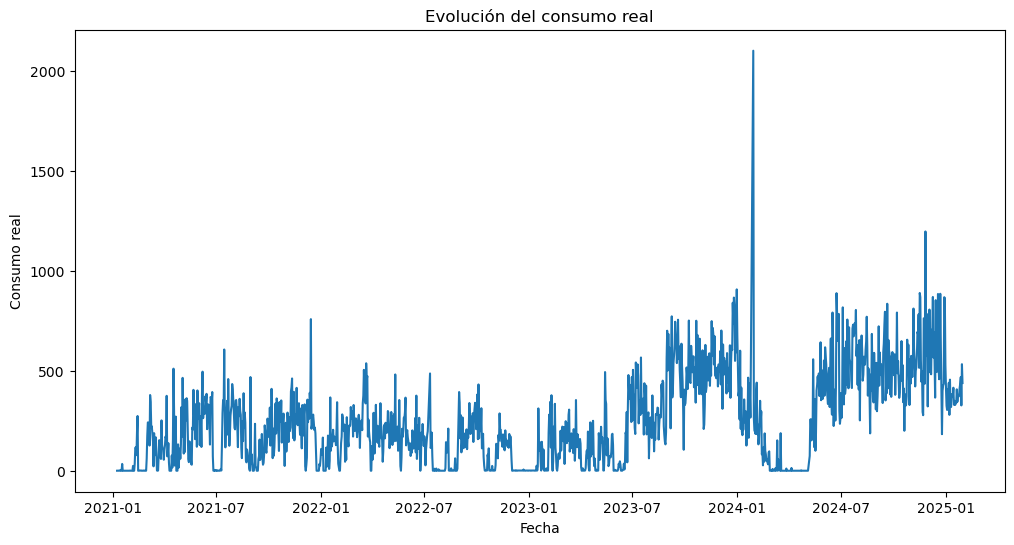

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_poliza, x='FECHA', y='CONSUMO_REAL')
plt.title('Evolución del consumo real')
plt.xlabel('Fecha')
plt.ylabel('Consumo real')
plt.show()

